In [1]:
import argparse
import os
import shutil
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import cv2
from MODELS.model_resnet import *
from PIL import ImageFile, Image
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
def validate(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top3 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()#async=True)
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)
            
            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)
            
            # measure accuracy and record loss
            prec1, prec3 = accuracy(output.data, target, topk=(1, 3))
            losses.update(loss.data.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))
            top3.update(prec3.item(), input.size(0))
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            if i % 10 == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@5 {top3.val:.3f} ({top3.avg:.3f})'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       top1=top1, top3=top3))
        
        print(' * Prec@1 {top1.avg:.3f} Prec@3 {top3.avg:.3f}'
                .format(top1=top1, top3=top3))

        return top1.avg, losses.avg

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res        

In [4]:
model = ResidualNet('CIFAR10', 18, 8, 'CBAM') #CBAM을 사용하고 싶다면 주석 해제
#model = ResidualNet('CIFAR10', 18, 8, None)
 #Vanilla를 사용하고 싶다면 주석 해제model = model.cuda()
t = torch.load('./checkpoints_dep/C_R20_lr01_E100_model_best.pth.tar')['state_dict'] #사용할 모델 경로 입력
model = torch.nn.DataParallel(model, device_ids=list(range(1)))
model.load_state_dict(t)

C:\Users\think\FER\MODELS\model_resnet.py:129: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\think\FER\MODELS\model_resnet.py:133: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


<All keys matched successfully>

In [5]:
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (cbam): CBAM(
          (ChannelGate): ChannelGate(
            (mlp): Sequential(
              (0): Flatten()
              (1): Linear(in_features=16, out_features=1, bias=True)
              (2): ReLU()
              (3): Linear(in_features=1, out_features=16, bias=True)
      

In [6]:
testdir = './FERPlus/data_new/FER_Test'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_images = datasets.ImageFolder(testdir, transforms.Compose([transforms.ToTensor(),normalize]))
test_loader = torch.utils.data.DataLoader(
    test_images,
    batch_size=64, shuffle=True, #shuffle = False,
    num_workers=4, pin_memory=True)

In [7]:
criterion = nn.CrossEntropyLoss().cuda()
validate(test_loader, model, criterion, 0)

C:\Users\think\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test: [0/56]	Time 6.072 (6.072)	Loss 0.9257 (0.9257)	Prec@1 71.875 (71.875)	Prec@5 95.312 (95.312)
Test: [10/56]	Time 0.021 (0.574)	Loss 0.8954 (0.8632)	Prec@1 76.562 (76.562)	Prec@5 96.875 (95.739)
Test: [20/56]	Time 0.019 (0.310)	Loss 1.2029 (0.8364)	Prec@1 67.188 (77.530)	Prec@5 93.750 (95.312)
Test: [30/56]	Time 0.019 (0.216)	Loss 1.0237 (0.8518)	Prec@1 81.250 (78.024)	Prec@5 93.750 (95.060)
Test: [40/56]	Time 0.018 (0.168)	Loss 0.7488 (0.8562)	Prec@1 76.562 (77.591)	Prec@5 95.312 (94.893)
Test: [50/56]	Time 0.018 (0.139)	Loss 0.6457 (0.8361)	Prec@1 84.375 (77.941)	Prec@5 93.750 (94.975)
 * Prec@1 77.947 Prec@3 95.093


(77.94698248538874, 0.8265180219315703)

In [8]:
target_layers = [model.module.layer3[-1]]

In [9]:
CAMdir = './FERPlus/data_new/CAM_Test'
CAM_images = datasets.ImageFolder(CAMdir, transforms.Compose([transforms.ToTensor(),normalize]))
CAM_loader = torch.utils.data.DataLoader(
    CAM_images,  shuffle = False,
    num_workers=4, pin_memory=True)
input_tensor = list(enumerate(CAM_loader))

pred_lab = []
sft = np.zeros(8)
with torch.no_grad():
        for i, (input, target) in enumerate(CAM_loader):
            target = target.cuda()#async=True)
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)
            
            output = model(input_var)
            output = nn.functional.softmax(output, dim = 1)
            sft[i], pred = torch.topk(output, 1)
            pred_lab.append(pred)
            

images = []
labels = []
for i in range(len(input_tensor)):
    images.append(input_tensor[i][1][0])
    labels.append(input_tensor[i][1][1])
cam = GradCAM(model = model, target_layers = target_layers, use_cuda = True)


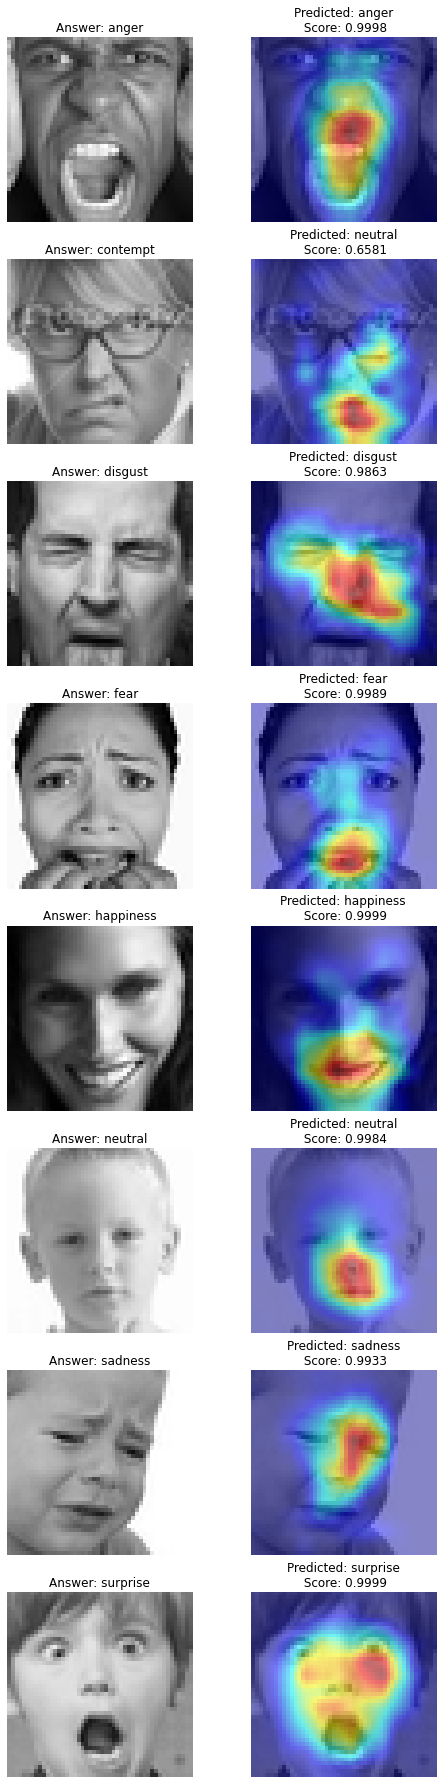

In [10]:
plt.figure(figsize = (8,32))
for i in range(len(CAM_images.classes)):
    c = cam(input_tensor = images[i])
    c = c[0, :]
    img_path = os.path.join(CAMdir, CAM_images.classes[i])
    img_dir = os.path.join(img_path, os.listdir(img_path)[0])
    rgb_img = cv2.imread(img_dir)[:,:,::-1]
    rgb_img = np.float32(rgb_img) / 255
    visualization = show_cam_on_image(rgb_img, c, use_rgb = True)
    img = Image.open(img_dir).convert('RGB')
    img = np.array(img)
    
    plt.subplot(8,2,i*2+1)
    plt.axis('off')
    plt.title('Answer: ' + CAM_images.classes[i])
    plt.imshow(img)
    
    a = CAM_images.classes[pred_lab[i]]
    
    plt.subplot(8,2,i*2+2)
    plt.axis('off')
    plt.title('Predicted: ' +a + '\n Score: ' + str(sft[i])[:6])
    plt.imshow(visualization)
plt.show()
